Vorarbeiten, Bibliotheken laden
 - normale
 - spacy
 - wordcloud

In [ ]:
# normale Bibliotheken laden
import urllib.request
import re
from collections import Counter
import pandas as pd

In [ ]:
# spacy Command Line Interface zum Installieren nutzen
import spacy.cli
spacy.cli.download("de_core_news_md")
 
# spacy laden
import spacy
nlp = spacy.load('de_core_news_md')

✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_md')


In [ ]:
# alles für WordCloud nötige
!pip install wordcloud
 
from wordcloud import WordCloud, STOPWORDS  # für Wordcloud - hier auch spezielle stopwrdliste laden
 
import matplotlib.pyplot as plt # zum Zeichnen der Wolke
import numpy as np              # zum Rechnen 
 
# bei Bedarf stopword erweitern
uninteressant = "insbesonders darüber"
liste_der_unerwuenschten_woerter = uninteressant.split()
STOPWORDS.update(liste_der_unerwuenschten_woerter)

Prozeduren definieren
 - lese Kapitel auf www.bibwlserver.com
 - lese alle Kapitel je Buch
 - top30 Wörter eines Buch bestimmen
 - wordcloud aus diesen Wörtern zeichnen


In [ ]:
# Buchkapitel lesen
def lese_kapitel(buch, kptnr):
    # Parameter, sonst steht python im Zugriiffsheader und das mögen manche server nicht
    user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; UTF8; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
    headers={'User-Agent':user_agent,} 
    
    # open a connection to a URL using urllib
    # url = "https://www.bibleserver.com/LUT/Markus1"
    if (buch == "Mat"):
        url = "https://www.bibleserver.com/LUT/Matth%C3%A4us" + kptnr  #übersetzer'.encode('punycode').decode() 
    elif (buch == "Rom"):
        url = "https://www.bibleserver.com/LUT/R%C3%B6mer" + kptnr  #übersetzer'.encode('punycode').decode() 
    elif (buch == "Heb"):
        url = "https://www.bibleserver.com/LUT/Hebr%C3%A4er" + kptnr  #übersetzer'.encode('punycode').decode() 
    else:  
        url = "https://www.bibleserver.com/LUT/"+ buch + "/" + kptnr
    # print(url)
      
    request=urllib.request.Request(url,None,headers) #The assembled request
 
    response = urllib.request.urlopen(request)
 
    data = response.read().decode(response.headers.get_content_charset()) # The data u need # decode nachUTF8 wegen Umlauten....
 
    # relevanten Teil rausschneiden
    phs = re.findall(r'<span class="verse-content--hover">(.*?)</span>',str(data))
    # print(phs)
    doc = ""
    for eachP in phs:
        doc = doc + " " + eachP
 
    return doc

In [ ]:
# alle Kapitel eines Buchs lesen und zusammenfügen
def lese_buch(buch,kapmax):        
    buchtext = ""
    kap      = 1
    while kap <= kapmax: 
        # print(kap)
        kapitel = lese_kapitel(buch,str(kap))
        buchtext = buchtext + kapitel
        kap = kap + 1
 
    return(buchtext)

Jetzt kommt die eigentliche Textanalyse mit Spacy

In [ ]:
def korr_token(tx):
    for token in tx:
        korr_dic_noun = {"gott":"Gott", "gottes":"Gott", "herr":"Herr", "herrn":"Herr"
                        , "jüngern":"Jünger" 
                         ,"leviten":"Levit" }

        korr_dic_verb ={"sage":"sagen", "sprecht":"sprechen", "siehe":"sehen", "grüßt":"grüßen", "isst":"essen"}                 
        
        if token.text.lower() in korr_dic_noun:
            token.lemma_ = korr_dic_noun[token.text.lower()]
            token.pos_   = "NOUN"

        if token.text.lower() in korr_dic_verb:
            token.lemma_ = korr_dic_verb[token.text.lower()]
            token.pos_   = "VERB"

        # Sonderfälle
        if token.lemma_.lower() == "sage" and token.pos_ != "NOUN":
            token.lemma_ = "sagen"     
            token.pos_ = "VERB" 
 
        if token.lemma_ == "sprachen":
            token.lemma_ = "sprechen"     
 
        if token.lemma_ == "weiß" and token.pos_ == "VERB":
            token.lemma_ = "wissen" 
 
        if token.lemma_ == "sollen" and token.pos_ == "VERB":
            token.pos_ = "AUX" 

    return(tx) 
 
 
def token_text(doc, pos_list):
    # tokenizer
    text= nlp(doc)
    # umkodieren, was besser geht
    text = korr_token(text)
 
    #remove stopwords and punctuations / nur noun verbs
    words = [token.lemma_ for token in text if token.is_stop != True and token.is_punct != True and pos_list.count(token.pos_)>0]
 
    word_freq = Counter(words)
    
    # Was sind die top 30?
    common_words = word_freq.most_common(30)
    t_dict = dict(common_words) # als dictionary speichern
 
    return t_dict

In [ ]:
def zeichne_worldcloud(t_dict,bname):
 
    # Maske für WordCloud erstellen
    #x, y = np.ogrid[:1500, :1500]
    #mask = (x - 700) ** 2 + (y - 700) ** 2 > 600 ** 2
    #mask = 255 * mask.astype(int)
 
    # Generate a word cloud image
    # wordcloud = WordCloud(background_color="white",width=1920, height=1080, mask=mask).generate_from_frequencies(mat_t) # mit Kreis-Maske
    wordcloud = WordCloud(background_color="black",width=1680, height=1260).generate_from_frequencies(t_dict) # Eingabe als dictionary wort:Anhzahl
    wordcloud.to_file(bname+".png") 
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    b = "Mat"
    plt.savefig("wordcloud"+b+".png")

Eigentliche Abarbeitung der Buchliste

1.Mose
{'sprechen': 467, 'Sohn': 287, 'Herr': 243, 'Vater': 196, 'Jakob': 174, 'Land': 164, 'Bruder': 164, 'sehen': 151, 'Frau': 148, 'Josef': 137, 'Abraham': 122, 'Erde': 120, 'Tochter': 103, 'ziehen': 97, 'gebären': 93, 'geben': 87, 'Haus': 87, 'Pharao': 85, 'Mann': 83, 'Knecht': 81, 'Hand': 75, 'lassen': 70, 'nennen': 69, 'nehmen': 69, 'kommen': 67, 'Isaak': 67, 'antworten': 66, 'sterben': 60, 'segnen': 58, 'bringen': 57}


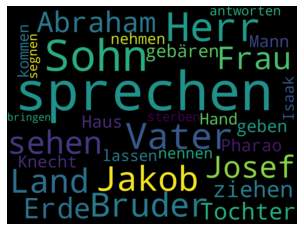

2.Mose
{'Herr': 414, 'Mose': 262, 'sprechen': 219, 'Volk': 173, 'Israelit': 113, 'Pharao': 111, 'Hand': 101, 'Aaron': 99, 'Sohn': 97, 'lassen': 89, 'sehen': 82, 'Ägypten': 64, 'ziehen': 62, 'Land': 61, 'Fuß': 60, 'Wohnung': 57, 'Ägyptenland': 56, 'Israel': 55, 'Elle': 54, 'Gold': 48, 'geben': 47, 'bringen': 46, 'Altar': 46, 'reden': 45, 'Berg': 43, 'Frau': 41, 'Wasser': 41, 'bieten': 41, 'sterben': 40, 'sagen': 39}


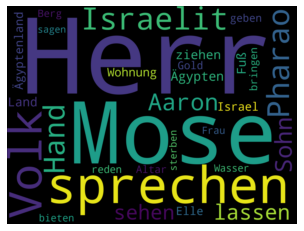

3.Mose
{'Herr': 311, 'Priester': 140, 'essen': 81, 'Altar': 79, 'Mose': 73, 'Blut': 73, 'bringen': 71, 'Land': 61, 'Sohn': 60, 'lassen': 57, 'sprechen': 55, 'Kleid': 53, 'Israelit': 52, 'Aaron': 51, 'Fett': 50, 'Volk': 50, 'Brandopfer': 49, 'Sündopfer': 47, 'Frau': 44, 'Stiftshütte': 43, 'darbringen': 42, 'Hand': 42, 'Wasser': 42, 'nehmen': 42, 'opfern': 41, 'Haus': 41, 'Stelle': 39, 'Tier': 36, 'geben': 36, 'reden': 35}


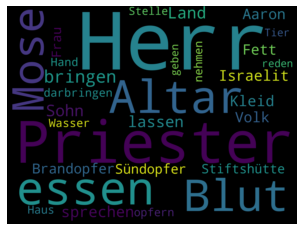

4.Mose
{'Herr': 399, 'Sohn': 234, 'Mose': 225, 'sprechen': 175, 'Israelit': 158, 'Geschlecht': 150, 'ziehen': 113, 'Land': 102, 'Stamm': 92, 'Mann': 86, 'Aaron': 82, 'Gemeinde': 81, 'reden': 80, 'Volk': 80, 'lagern': 74, 'geben': 73, 'Israel': 69, 'Widder': 65, 'Fürst': 64, 'Lamm': 64, 'Stiftshütte': 62, 'Priester': 59, 'sterben': 56, 'Brandopfer': 54, 'Levit': 53, 'sehen': 53, 'Speisopfer': 53, 'Stier': 53, 'Heer': 51, 'nehmen': 49}


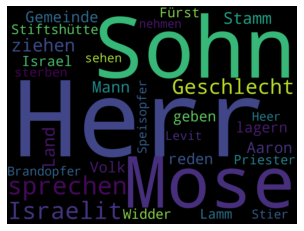

5.Mose
{'Herr': 540, 'Land': 174, 'Volk': 138, 'geben': 114, 'Gott': 86, 'Stadt': 82, 'sprechen': 78, 'Vater': 71, 'Hand': 69, 'tun': 68, 'essen': 66, 'Sohn': 61, 'sehen': 59, 'nehmen': 58, 'halten': 58, 'Israel': 55, 'Gebot': 55, 'ziehen': 52, 'sagen': 51, 'Herz': 48, 'Bruder': 47, 'einnehmen': 47, 'Auge': 46, 'Frau': 46, 'wohnen': 44, 'Himmel': 43, 'hören': 43, 'Wort': 42, 'reden': 42, 'Berg': 41}


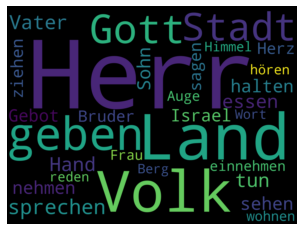

<Figure size 432x288 with 0 Axes>

In [ ]:
# #############################################################################
# Hier werden die Parameter für alles festgelegt
# #############################################################################
 
# Welche Bücher werden genauer angeschaut?
buecher = [("1.Mose",50),("2.Mose",40),("3.Mose",27),("4.Mose",36),("5.Mose",34)]
#buecher = [("Mat",18), ("Markus",28),("Apostelgeschichte",28), ("Rom",16)]
#buecher = [("Mat",18)]
 
# alle relevanten Wörter prüfen, in wievielen von allen Büchern sie vorkommen
alle_buecher = [("1.Mose",50),("2.Mose",40),("3.Mose",27),("4.Mose",36),("5.Mose",34)
               # ("Mat",18), ("Markus",28)
               #, ("Lukas",24), ("Johannes",21)
               #, ("Apostelgeschichte",28)
               #,("Rom",16)
               #, ("1.Korinther",16), ("2.Korinther",13), ("Galater",6), ("Epheser",6), ("Philipper",4), ("Kolosser",4)
               #,("1.Thessalonicher",5), ("2.Thessalonicher",3), ("1.Timotheus",6), ("2.Timotheus",4), ("Titus",3), ("Philemon",1)
               #,("Heb",13), ("Jakobus",5), ("1.Petrus",5), ("2.Petrus",3), ("1.Johannes",5), ("2.Johannes",1), ("3.Johannes",1), ("Judas",1)
               #,("Offenbarung",22)
               ]
 
# Welche Wortarten kommen in die Untersuchung?
pos_list = ["NOUN", "PROPN","VERB"]
#pos_list = ["VERB"]
 
 
# alle relevanten Wörter in eine Liste schreiben
buch_liste       = [] # buchliste für später ablegen
wichtige_woerter = set() # top30-Wörter alle i neine Liste schreiben (set vermeidet doppelte Elemente)
woerter_je_buch  = []    # Ergebnisliste anlegen (Buch + Top30)
 
# --------------------------------------------------------
# Hauptprogramm 1 - Buchanalyse / Was sind die top-Wörter?
# --------------------------------------------------------
lfnr = 1
for b, mk in buecher:
    print(b)    
    lfnr_b = (b, lfnr)
    buch_liste.append(b) # die untersuchten Bücher werden der Reihe nach abgelegt
    buchtext = lese_buch(b,mk)
    top30    = token_text(buchtext, pos_list)
    print(top30)
    zeichne_worldcloud(top30,b)
 
    wichtige_woerter.update(top30.keys())   
    woerter_je_buch.append((b,top30))  # also buch + top30 als Eintrag wegschreiben        
 
    lfnr = lfnr + 1

Wie selektiv sind die gefundenen Wörter eigentlich?
rel. Häufigkeit im Text * Selektivität im Corpus    
d.h.  (wie oft/max wie oft) * log 10 ( Anzahl Dokumente im Corpus / Anzahl Dokumente mit disem Wort)

In [ ]:
df_anzahl = len(alle_buecher)
df_cnt = pd.DataFrame(columns =  ["buch"] + list(wichtige_woerter))
df_cnt.set_index("buch", inplace=True)
 
# lese alle Bücher
for b, mk in alle_buecher:    
    print(b)
    buchtext = lese_buch(b,mk)
    token_buch = nlp(buchtext, pos_list)
    token_buch = korr_token(token_buch)
 
    # alle lemma in eine Liste packen
    lemma_list = []
    for t in token_buch:
        lemma_list.append(t.lemma_)
 
    # und in set umwandeln, denn so kommt jedes Wort nur einmal vor
    lemma_list = set(lemma_list) 
 
    # prüfe jedes Wort im untersuchten Buch    
    for lem in lemma_list:
        # vergleiche es mit jedem Wort aus relevanter Liste
        for k in wichtige_woerter:
            if k == lem: # sind sie gleich, erhöhe den Zähler für relevantes Wort
                df_cnt.at[b,lem] = 1
 
df_cnt.fillna(0, inplace=True) # NA auf 0 setzen, damit später besser gerechnet werden kann
df_cnt_ges = df_cnt.sum()

1.Mose
2.Mose
3.Mose
4.Mose
5.Mose


In [ ]:
# wie wichtig ist ein Wort (Kommt es oft vor und ist es sensitiv?) in untersuchten Buch
# tf-idf Wert bestimmen
def wie_wichtig_ist_wort(top):
    tf_liste = []
    lfnr = 1
    for (w,a) in top.items():
        # da Top Wörter gesucht wurden, hat erster Listen-Eintrag tf = 1
        if lfnr == 1:
            n_max = a
 
        # tf = relative Häufigkeit eines Wortes in einem Dokument     
        tf = a /n_max
 
        # idf(Wort) = log ( Anzahl aller Dokument im Korpus / Anzahl Dokumente mit dem Wort) 
        idf = np.log10(df_anzahl / df_cnt_ges[w] )
        if  df_cnt_ges[w] > 0:
            z = 1
        else:    
            print(w,df_cnt_ges[w])
 
        # Wichtigkeit =  tf * idf
        tf_liste.append((w,tf,idf, tf*idf))
 
        lfnr = lfnr + 1
 
    return(tf_liste)

In [ ]:
# Je Buch die interessantesten Wörter listen
z_l = ["buch"] + list(wichtige_woerter)
wiwis = pd.DataFrame(columns =  z_l)
wiwis.set_index("buch", inplace=True)
 
# schleife über alle untersuchten Bücher
for b,topxx in woerter_je_buch:
    wichtig_liste = wie_wichtig_ist_wort(topxx)
    #print(wichtig_liste)
    for w in wichtig_liste:
      # je Buch wird zum relevanten Wort die Wichtigkeit geschrieben
      # um integer-Häufigkeit zu simulieren Multiplikation mit 10.000
      z = round(10000 * w[3]) 
      wiwis.at[b,w[0]] = int(z)  
      
 
wiwis.fillna(0, inplace=True)
print(wiwis)

        Herr  Bruder  bieten  Stamm  ...  Geschlecht  Gebot  Tochter  sagen
buch                                 ...                                   
1.Mose     0       0       0      0  ...           0      0        0      0
2.Mose     0       0       0      0  ...           0      0        0      0
3.Mose     0       0       0      0  ...           0      0        0      0
4.Mose     0       0       0      0  ...           0      0        0      0
5.Mose     0       0       0      0  ...           0      0        0      0

[5 rows x 82 columns]


1.Mose


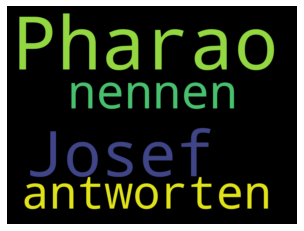

2.Mose


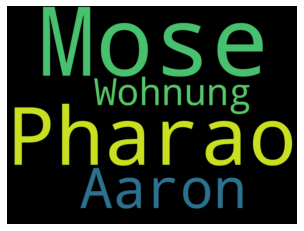

3.Mose


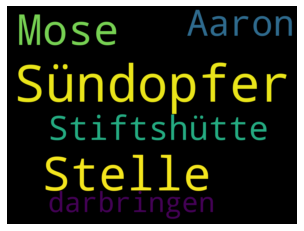

4.Mose


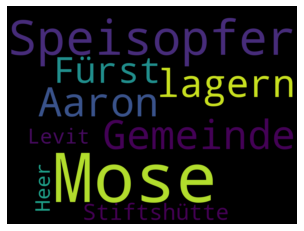

5.Mose


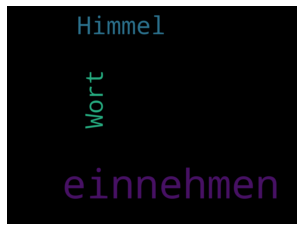

<Figure size 432x288 with 0 Axes>

In [ ]:
# Neue Worldcloud mit Selektivität/Wichtigkeit des Wortes relativ zu Buch und Corpus(!) zeichnen
wiwis_tp = wiwis.transpose()
 
for buch in buch_liste:
    print(buch) 
 
    t_dict = wiwis_tp[buch]  # Buch mit Werten je wichtigem Wort aus DataFrame schneiden
 
    # für wordcloud-Aufruf dict basteln, damit frequencies-Option gewählt werden kann
    z_wocl_dic = {}  # leeres dict anlgen  
    for (k,v) in t_dict.items():
        if v > 0:
            z_wocl_dic.update({k:v}) # lemma und frequenz eintragen
 
    zeichne_worldcloud(z_wocl_dic, buch+"sel")  # worldcloud zeichnen

In [ ]:
print(buch_liste)

['1.Mose', '2.Mose', '3.Mose', '4.Mose', '5.Mose']


In [ ]:
# ner Noun Entity Relation
#doc = """1 Es begab sich aber zu der Zeit, dass ein Gebot von dem Kaiser Augustus ausging, dass alle Welt geschätzt würde. 
#2 Und diese Schätzung war die allererste und geschah zur Zeit, da Quirinius Statthalter in Syrien war. 
#3 Und jedermann ging, dass er sich schätzen ließe, ein jeglicher in seine Stadt. 
#4 Da machte sich auf auch Josef aus Galiläa, aus der Stadt Nazareth, in das judäische Land zur Stadt Davids, die da heißt Bethlehem, darum dass er von dem Hause und Geschlechte Davids war,
#5 auf dass er sich schätzen ließe mit Maria, seinem vertrauten Weibe; die war schwanger. 
#6 Und als sie daselbst waren, kam die Zeit, dass sie gebären sollte.
#7 Und sie gebar ihren ersten Sohn und wickelte ihn in Windeln und legte ihn in eine Krippe; denn sie hatten sonst keinen Raum in der Herberge. 
#8 Und es waren Hirten in derselben Gegend auf dem Felde bei den Hürden, die hüteten des Nachts ihre Herde. 
#9 Und des Herrn Engel trat zu ihnen, und die Klarheit des Herrn leuchtete um sie; und sie fürchteten sich sehr. 
#10 Und der Engel sprach zu ihnen: Fürchtet euch nicht! Siehe, ich verkündige euch große Freude, die allem Volk widerfahren wird; 
#11 denn euch ist heute der Heiland geboren, welcher ist Christus, der Herr, in der Stadt Davids. 
#12 Und das habt zum Zeichen: Ihr werdet finden das Kind in Windeln gewickelt und in einer Krippe liegen. 
#13 Und alsbald war da bei dem Engel die Menge der himmlischen Heerscharen, die lobten Gott und sprachen: 
#14 Ehre sei Gott in der Höhe und Friede auf Erden bei den Menschen seines Wohlgefallens. 
#15 Und da die Engel von ihnen gen Himmel fuhren, sprachen die Hirten untereinander: Lasst uns nun gehen gen Bethlehem und die Geschichte sehen, die da geschehen ist, die uns der Herr kundgetan hat. 
#16 Und sie kamen eilend und fanden beide, Maria und Josef, dazu das Kind in der Krippe liegen. 
#17 Da sie es aber gesehen hatten, breiteten sie das Wort aus, welches zu ihnen von diesem Kinde gesagt war. 
#18 Und alle, vor die es kam, wunderten sich über die Rede, die ihnen die Hirten gesagt hatten.
#19 Maria aber behielt alle diese Worte und bewegte sie in ihrem Herzen. 
#20 Und die Hirten kehrten wieder um, priesen und lobten Gott für alles, was sie gehört und gesehen hatten, wie denn zu ihnen gesagt war."""
doc = " Und Gottes Hand kommt und hilft"
text = nlp(doc)
labels = set([w.label_ for w in text.ents]) 
for label in labels: # d.h. für alle gefundenen Kategorien
    entities = [e.string for e in text.ents if label==e.label_] # sammel alle Wörter, wenn sie zum aktuellen "Label" passen 
    entities = list(set(entities))   # in eine Liste von einem set (set erzeugt EIndeutigkeit, Liste ist schöner in Ausgabe)
    print( label,entities) 

In [ ]:
# Spielwiese zum Testen
doc = lese_buch("Mat",16)
text= nlp(doc)
words = [token.lemma_ for token in text if token.is_stop != True and token.is_punct != True ]
wz = Counter(words)

#print(wz)

freq = Counter(doc.split())
#print(freq)
print(freq['Gott'])
print(freq['Gottes'])

8
14


In [ ]:
# Spielwiese zum Testen
korr_dic = {"herr":"Herr", "herrn":"Herr", "leviten":"Levit" }
z_w = "HErr"
if z_w.lower() in korr_dic:
    z_x = korr_dic[z_w.lower()]
else:
    z_x = z_w
print(z_x)

Herr
